<a href="https://colab.research.google.com/github/mkayanda/Personal_Projects/blob/master/Rating_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import json 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 1000

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [1]:
root_path = '/content/drive/MyDrive/googleplaystore.csv' 

In [4]:
google_play_raw = pd.read_csv(root_path)

In [6]:
google_play_raw.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide Apps",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [7]:
google_play_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [8]:
google_play_raw['Category'].value_counts()

FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     231
VIDEO_PLAYERS           175
EDUCATION               156
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     137
FOOD_AND_DRINK          127
HOUSE_AND_HOME           88
LIBRARIES_AND_DEMO       85
AUTO_AND_VEHICLES        85
WEATHER                  82
ART_AND_DESIGN           65
EVENTS                   64
PARENTING                60
COMICS                   60
BEAUTY                   53
1.9                       1
Name: Category, dtype: int64

In [9]:
google_play_raw['Genres'].value_counts().head(20)

Tools                842
Entertainment        623
Education            549
Medical              463
Business             460
Productivity         424
Sports               398
Personalization      392
Communication        387
Lifestyle            381
Finance              366
Action               365
Health & Fitness     341
Photography          335
Social               295
News & Magazines     283
Shopping             260
Travel & Local       257
Dating               234
Books & Reference    231
Name: Genres, dtype: int64

In [10]:
google_play_raw['Genres'].nunique()

120

In [11]:
filtered_columns = ['App','text','Rating','Reviews','Installs']
googleplay_filtered = google_play_raw.reindex(columns = filtered_columns)
googleplay_filtered = googleplay_filtered[googleplay_filtered['Rating'] == 5]

In [12]:
googleplay_filtered.head()

,App,text,Rating,Reviews,Installs
329,Hojiboy Tojiboyev Life Hacks,NaN,5.0,15,"1,000+"
612,American Girls Mobile Numbers,NaN,5.0,5,"1,000+"
615,Awake Dating,NaN,5.0,2,100+
633,Spine- The dating app,NaN,5.0,5,500+
636,Girls Live Talk - Free Text and Video Chat,NaN,5.0,6,100+


In [13]:
len(googleplay_filtered)

274

In [14]:
# Check if there's any app has rating over 5, which means the data might be noisy 
google_play_raw.loc[google_play_raw["Rating"] > 5]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [15]:
#drop all nulls
google_play_cleaned = google_play_raw.loc[google_play_raw["Rating"].notnull()]

In [16]:
#grab only observation of 5 and below
google_play_cleaned = google_play_cleaned.loc[google_play_cleaned["Rating"] <= 5]

In [17]:
#Price is now as a object type, we'll need to drop the dollar sign

google_play_cleaned['Price'].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$7.99', '$5.99', '$2.99', '$3.49',
       '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49', '$10.00',
       '$24.99', '$11.99', '$79.99', '$16.99', '$14.99', '$29.99',
       '$12.99', '$2.49', '$10.99', '$1.50', '$19.99', '$15.99', '$33.99',
       '$39.99', '$3.95', '$4.49', '$1.70', '$8.99', '$1.49', '$3.88',
       '$399.99', '$17.99', '$400.00', '$3.02', '$1.76', '$4.84', '$4.77',
       '$1.61', '$2.50', '$1.59', '$6.49', '$1.29', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$8.49', '$1.75', '$14.00', '$2.00',
       '$3.08', '$2.59', '$19.40', '$3.90', '$4.59', '$15.46', '$3.04',
       '$13.99', '$4.29', '$3.28', '$4.60', '$1.00', '$2.95', '$2.90',
       '$1.97', '$2.56', '$1.20'], dtype=object)

In [18]:
google_play_cleaned["Price"] = google_play_cleaned["Price"].apply(lambda x: x.replace('$', ''))

In [19]:
google_play_cleaned['Price'].unique()

array(['0', '4.99', '3.99', '6.99', '7.99', '5.99', '2.99', '3.49',
       '1.99', '9.99', '7.49', '0.99', '9.00', '5.49', '10.00', '24.99',
       '11.99', '79.99', '16.99', '14.99', '29.99', '12.99', '2.49',
       '10.99', '1.50', '19.99', '15.99', '33.99', '39.99', '3.95',
       '4.49', '1.70', '8.99', '1.49', '3.88', '399.99', '17.99',
       '400.00', '3.02', '1.76', '4.84', '4.77', '1.61', '2.50', '1.59',
       '6.49', '1.29', '299.99', '379.99', '37.99', '18.99', '389.99',
       '8.49', '1.75', '14.00', '2.00', '3.08', '2.59', '19.40', '3.90',
       '4.59', '15.46', '3.04', '13.99', '4.29', '3.28', '4.60', '1.00',
       '2.95', '2.90', '1.97', '2.56', '1.20'], dtype=object)

In [20]:
google_play_cleaned['Price'] = google_play_cleaned['Price'].astype(float, errors = 'raise')

In [21]:
google_play_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9366 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9366 non-null   object 
 1   Category        9366 non-null   object 
 2   Rating          9366 non-null   float64
 3   Reviews         9366 non-null   object 
 4   Size            9366 non-null   object 
 5   Installs        9366 non-null   object 
 6   Type            9366 non-null   object 
 7   Price           9366 non-null   float64
 8   Content Rating  9366 non-null   object 
 9   Genres          9366 non-null   object 
 10  Last Updated    9366 non-null   object 
 11  Current Ver     9362 non-null   object 
 12  Android Ver     9364 non-null   object 
dtypes: float64(2), object(11)
memory usage: 1.0+ MB


In [22]:
top30_genres = google_play_cleaned["Genres"].value_counts().head(30).index

In [23]:
top30_genres

Index(['Tools', 'Entertainment', 'Education', 'Action', 'Productivity',
       'Medical', 'Sports', 'Communication', 'Finance', 'Photography',
       'Personalization', 'Lifestyle', 'Business', 'Health & Fitness',
       'Social', 'Shopping', 'News & Magazines', 'Travel & Local', 'Arcade',
       'Dating', 'Simulation', 'Casual', 'Books & Reference',
       'Video Players & Editors', 'Maps & Navigation', 'Puzzle',
       'Food & Drink', 'Role Playing', 'Strategy', 'Racing'],
      dtype='object')

In [24]:
google_play_cleaned["Genres"] = google_play_cleaned["Genres"].apply(lambda x: x if x in top30_genres else "Other")


In [25]:
google_play_cleaned["Genres"].unique()

array(['Other', 'Books & Reference', 'Business', 'Communication',
       'Dating', 'Education', 'Entertainment', 'Finance', 'Food & Drink',
       'Health & Fitness', 'Lifestyle', 'Arcade', 'Casual', 'Action',
       'Strategy', 'Puzzle', 'Sports', 'Racing', 'Simulation',
       'Role Playing', 'Medical', 'Social', 'Shopping', 'Photography',
       'Travel & Local', 'Tools', 'Personalization', 'Productivity',
       'Video Players & Editors', 'News & Magazines', 'Maps & Navigation'],
      dtype=object)

In [26]:
def value_to_float(x):
    """
    Convert the string feature into float.
    If there is 'K' or 'M' in the string, convert it to the corresponding number (1000 or 1000000). 
    """
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 10**3
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 10**6
        return 1000000.0
    
    # If the string cannot be converted, return 0 instead
    try:
        parsed_val = float(x)
    except ValueError:
        parsed_val = 0.0
    return parsed_val

In [27]:
str_cols = ["Reviews", "Size", "Price"]

for col in str_cols:
    google_play_cleaned[[col]] = google_play_cleaned[[col]].fillna(value="")
    google_play_cleaned[col] = google_play_cleaned[col].apply(value_to_float)

In [28]:
google_play_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,9366.0,4.191757e+00,5.152189e-01,1.0,4.00,4.3,4.50,5.0
Reviews,9366.0,5.140498e+05,3.144042e+06,1.0,186.25,5930.5,81532.75,78158306.0
Size,9366.0,1.893322e+07,2.302330e+07,0.0,2400000.00,9500000.0,27000000.00,100000000.0
Price,9366.0,9.609278e-01,1.581658e+01,0.0,0.00,0.0,0.00,400.0


In [29]:
# To get a brief idea about the apps whose prices are higher than $50
google_play_cleaned.loc[google_play_cleaned["Price"] > 50]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2253,Vargo Anesthesia Mega App,MEDICAL,4.6,92.0,32000000.0,"1,000+",Paid,79.99,Everyone,Medical,"June 18, 2018",19.0,4.0.3 and up
2365,Vargo Anesthesia Mega App,MEDICAL,4.6,92.0,32000000.0,"1,000+",Paid,79.99,Everyone,Medical,"June 18, 2018",19.0,4.0.3 and up
4197,most expensive app (H),FAMILY,4.3,6.0,1500000.0,100+,Paid,399.99,Everyone,Entertainment,"July 16, 2018",1.0,7.0 and up
4362,💎 I'm rich,LIFESTYLE,3.8,718.0,26000000.0,"10,000+",Paid,399.99,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275.0,7300000.0,"10,000+",Paid,400.00,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up
5351,I am rich,LIFESTYLE,3.8,3547.0,1800000.0,"100,000+",Paid,399.99,Everyone,Lifestyle,"January 12, 2018",2.0,4.0.3 and up
5354,I am Rich Plus,FAMILY,4.0,856.0,8700000.0,"10,000+",Paid,399.99,Everyone,Entertainment,"May 19, 2018",3.0,4.4 and up
5355,I am rich VIP,LIFESTYLE,3.8,411.0,2600000.0,"10,000+",Paid,299.99,Everyone,Lifestyle,"July 21, 2018",1.1.1,4.3 and up
5356,I Am Rich Premium,FINANCE,4.1,1867.0,4700000.0,"50,000+",Paid,399.99,Everyone,Finance,"November 12, 2017",1.6,4.0 and up
5357,I am extremely Rich,LIFESTYLE,2.9,41.0,2900000.0,"1,000+",Paid,379.99,Everyone,Lifestyle,"July 1, 2018",1.0,4.0 and up


Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'Rating Distribution')

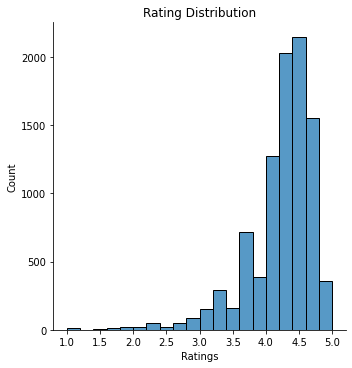

In [30]:
# Perform Exploratory Data Analysis (EDA)
%pylab inline

fig = sns.displot(google_play_cleaned["Rating"], bins=20)   
fig.set_xlabels('Ratings')
plt.title('Rating Distribution')

In [31]:
top10_category = google_play_cleaned["Category"].value_counts().head(10).index
df_top10_category = google_play_cleaned.loc[google_play_cleaned["Category"].isin(top10_category)]

Text(0, 0.5, 'App Count')

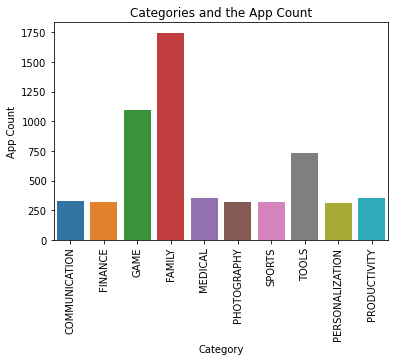

In [32]:
fig = sns.countplot(x="Category", data=df_top10_category)
fig.set_xlabel('Category')

plt.xticks(rotation=90)
plt.title('Categories and the App Count')
plt.ylabel('App Count')

Text(0.5, 1.0, 'Review Distribution')

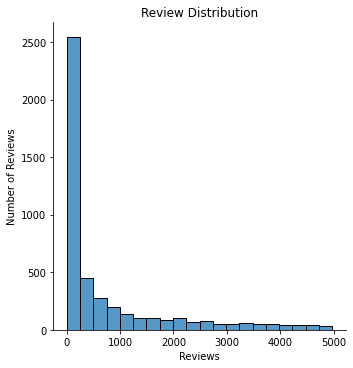

In [33]:
fig = sns.displot(google_play_cleaned.loc[google_play_cleaned["Reviews"] < 5000, "Reviews"], bins=20)
fig.set_axis_labels(x_var="Reviews", y_var="Number of Reviews")
plt.title('Review Distribution')

Text(0.5, 1.0, 'Size Distribution')

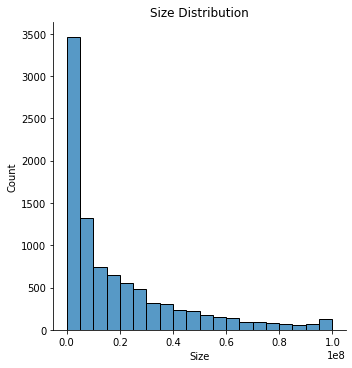

In [34]:
fig = sns.displot(google_play_cleaned["Size"], bins=20)
fig.set_xlabels('Size')
plt.title('Size Distribution')

Text(0.5, 1.0, 'Price Distribution')

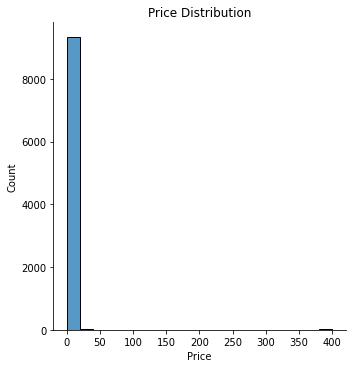

In [35]:
fig = sns.displot(google_play_cleaned["Price"], bins=20, )
fig.set_xlabels('Price')
plt.title('Price Distribution')

Text(0, 0.5, 'App Count')

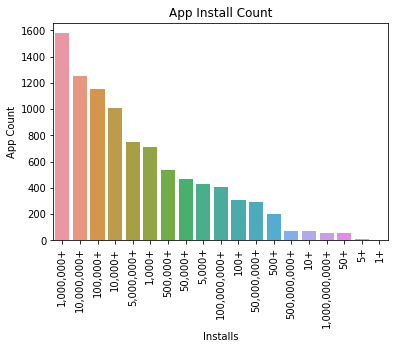

In [36]:
fig = sns.countplot(x="Installs", data=google_play_cleaned, order=google_play_cleaned['Installs'].value_counts().index)
fig.set_xlabel('Installs')

plt.xticks(rotation=90)
plt.title('App Install Count')
plt.ylabel('App Count')

Text(0, 0.5, 'App Count')

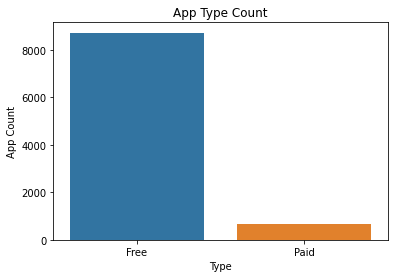

In [37]:
fig = sns.countplot(x="Type", data=google_play_cleaned)
fig.set_xlabel('Type')
plt.title('App Type Count')
plt.ylabel('App Count')

Text(0, 0.5, 'App Count')

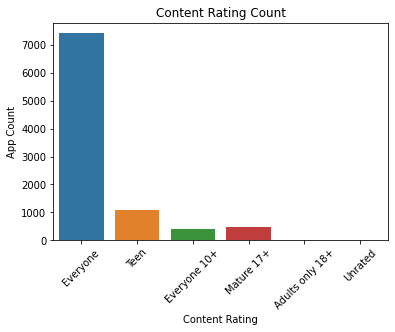

In [38]:
fig = sns.countplot(x="Content Rating", data=google_play_cleaned)
fig.set_xlabel('Content Rating')
plt.xticks(rotation=45)
plt.title('Content Rating Count')
plt.ylabel('App Count')

In [39]:
top10_genres = google_play_cleaned["Genres"].value_counts().head(10).index
df_top10_genres = google_play_cleaned.loc[google_play_cleaned["Genres"].isin(top10_genres)]

In [40]:
df_top10_category.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847.0,0.0,"1,000,000,000+",Free,0.0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316.0,0.0,"1,000,000,000+",Free,0.0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
337,Messenger for SMS,COMMUNICATION,4.3,125257.0,17000000.0,"10,000,000+",Free,0.0,Teen,Communication,"June 6, 2018",1.8.9,4.1 and up
338,Google Chrome: Fast & Secure,COMMUNICATION,4.3,9642995.0,0.0,"1,000,000,000+",Free,0.0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
339,Messenger Lite: Free Calls & Messages,COMMUNICATION,4.4,1429035.0,0.0,"100,000,000+",Free,0.0,Everyone,Communication,"July 25, 2018",37.0.0.7.163,2.3 and up


In [41]:
len(df_top10_category)

5880

Text(0, 0.5, 'App Count')

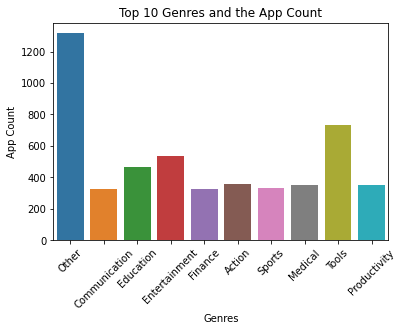

In [42]:
fig = sns.countplot(x="Genres", data=df_top10_genres)
fig.set_xlabel('Genres')

plt.xticks(rotation=45)
plt.title('Top 10 Genres and the App Count')
plt.ylabel('App Count')

In [43]:
top10_android = google_play_cleaned["Android Ver"].value_counts().head(10).index
df_top10_android = google_play_cleaned.loc[google_play_cleaned["Android Ver"].isin(top10_android)]

Text(0, 0.5, 'App Count')

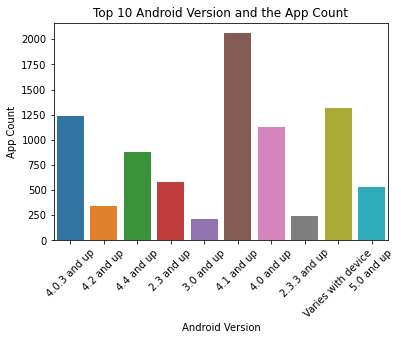

In [44]:
fig = sns.countplot(x="Android Ver", data=df_top10_android)
fig.set_xlabel('Android Version')

plt.xticks(rotation=45)
plt.title('Top 10 Android Version and the App Count')
plt.ylabel('App Count')

In [45]:
google_play_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9366 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9366 non-null   object 
 1   Category        9366 non-null   object 
 2   Rating          9366 non-null   float64
 3   Reviews         9366 non-null   float64
 4   Size            9366 non-null   float64
 5   Installs        9366 non-null   object 
 6   Type            9366 non-null   object 
 7   Price           9366 non-null   float64
 8   Content Rating  9366 non-null   object 
 9   Genres          9366 non-null   object 
 10  Last Updated    9366 non-null   object 
 11  Current Ver     9362 non-null   object 
 12  Android Ver     9364 non-null   object 
dtypes: float64(4), object(9)
memory usage: 1.3+ MB


In [46]:
# Create one-hot encoding for categorical features
categorical_feeatures = ["Category", "Installs", "Type", "Content Rating", "Genres", "Android Ver"]

for col in categorical_feeatures:
    one_hot = pd.get_dummies(google_play_cleaned[col], prefix=col+"_")
    google_play_cleaned = google_play_cleaned.drop(col, axis=1)
    google_play_cleaned = google_play_cleaned.join(one_hot)
    
google_play_cleaned = google_play_cleaned.drop(["App", "Last Updated", "Current Ver"], axis=1)

In [47]:
features = google_play_cleaned.drop("Rating", axis=1)
labels = google_play_cleaned["Rating"].values

In [48]:
# Split training/test data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

In [49]:
# Scale the features to make sure they are in similar ranges
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [50]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train_scaled, y_train)

# Make predictions using the train/testing set
y_pred_train = regr.predict(X_train_scaled)
y_pred_test = regr.predict(X_test_scaled)

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print("Mean squared error (train): %.2f"
      % mean_squared_error(y_train, y_pred_train))
print("Mean squared error (test): %.2f"
      % mean_squared_error(y_test, y_pred_test))

# R-squared on training set: 1 is perfect prediction
print('R-squared (train): %.2f' % r2_score(y_train, y_pred_train))
# R-squared on test set: 1 is perfect prediction
print('R-squared (test): %.2f' % r2_score(y_test, y_pred_test))

Coefficients: 
 [ 3.72540922e-01 -1.55432013e-02 -3.92766488e-01  4.45964425e+10
  4.45964425e+10  4.45964425e+10  8.91043508e+10  1.73686434e+11
  4.45964425e+10 -8.99280984e+10  1.65485674e+10  4.45964425e+10
  4.45964425e+10  4.45964425e+10  4.45964425e+10  1.89385994e+10
  2.46081708e+10  4.45964425e+10  6.98155697e+10  4.45964425e+10
  4.45964425e+10  4.45964425e+10  1.57854762e+10  3.73426866e+10
  3.83263245e+10  4.45964425e+10  2.83429960e+10  1.61085572e+10
  9.35631159e+10  1.57634323e+10 -2.04317126e+09  4.45964425e+10
  4.45964425e+10  4.45964425e+10  4.45964425e+10  4.45964425e+10
 -7.60749623e+10 -7.60749623e+10 -7.60749623e+10 -7.60749623e+10
 -7.60749623e+10 -7.60749623e+10 -7.60749623e+10 -7.60749623e+10
 -7.60749623e+10 -7.60749623e+10 -7.60749623e+10 -7.60749623e+10
 -7.60749623e+10 -7.60749623e+10 -7.60749623e+10 -7.60749623e+10
 -7.60749623e+10 -7.60749623e+10 -7.60749623e+10  1.70910896e+11
  1.70910896e+11 -2.59749875e+10 -2.59749875e+10 -2.59749875e+10
 -2.59749

In [51]:
# Set the parameters by cross-validation
tuned_parameters = [
    {
        'max_depth': [2, 3, 4, 5], 
        'learning_rate': [0.2, 0.1, 0.05, 0.01],
        'subsample': [1.0, 0.9, 0.8]
    }
]

print("# Tuning hyper-parameters")

# Train a GBDT regressor
clf = GridSearchCV(GradientBoostingRegressor(), tuned_parameters, cv=5, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

# Tuning hyper-parameters


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...ne,
                         

In [52]:
print("Best parameters set found on training set:")
print(clf.best_params_)

Best parameters set found on training set:
{'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.8}


In [53]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("Mean squared error = %0.3f for %r" % (-mean, params))

Mean squared error = 0.234 for {'learning_rate': 0.2, 'max_depth': 2, 'subsample': 1.0}
Mean squared error = 0.233 for {'learning_rate': 0.2, 'max_depth': 2, 'subsample': 0.9}
Mean squared error = 0.235 for {'learning_rate': 0.2, 'max_depth': 2, 'subsample': 0.8}
Mean squared error = 0.233 for {'learning_rate': 0.2, 'max_depth': 3, 'subsample': 1.0}
Mean squared error = 0.231 for {'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.9}
Mean squared error = 0.232 for {'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.8}
Mean squared error = 0.231 for {'learning_rate': 0.2, 'max_depth': 4, 'subsample': 1.0}
Mean squared error = 0.232 for {'learning_rate': 0.2, 'max_depth': 4, 'subsample': 0.9}
Mean squared error = 0.236 for {'learning_rate': 0.2, 'max_depth': 4, 'subsample': 0.8}
Mean squared error = 0.235 for {'learning_rate': 0.2, 'max_depth': 5, 'subsample': 1.0}
Mean squared error = 0.237 for {'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.9}
Mean squared error = 0.237 for {

In [54]:
best_estimator = clf.best_estimator_

In [55]:
# Make predictions using the train/testing set
y_pred_train = best_estimator.predict(X_train)
y_pred_test = best_estimator.predict(X_test)

# The mean squared error
print("Mean squared error (train): %.2f"
      % mean_squared_error(y_train, y_pred_train))
print("Mean squared error (test): %.2f"
      % mean_squared_error(y_test, y_pred_test))

# R-squared on training set: 1 is perfect prediction
print('R-squared (train): %.2f' % r2_score(y_train, y_pred_train))
# R-squared on test set: 1 is perfect prediction
print('R-squared (test): %.2f' % r2_score(y_test, y_pred_test))

Mean squared error (train): 0.19
Mean squared error (test): 0.20
R-squared (train): 0.31
R-squared (test): 0.15


In [56]:
best_n_estimators = best_estimator.get_params()["n_estimators"]

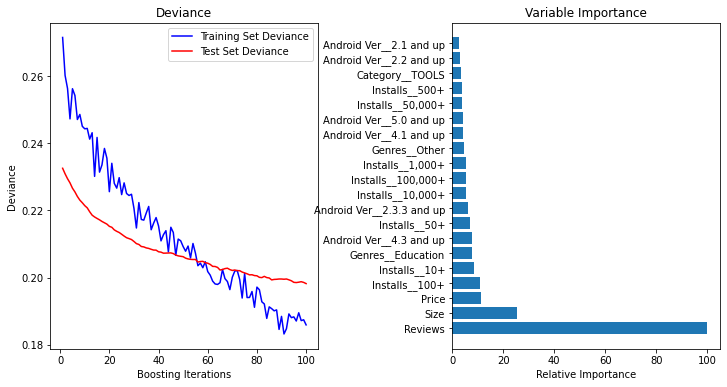

In [57]:
# Plot training deviance

# Compute test set deviance
test_score = np.zeros((best_n_estimators,), dtype=np.float64)
 
for i, y_pred_test in enumerate(best_estimator.staged_predict(X_test)):
    test_score[i] = best_estimator.loss_(y_test, y_pred_test)
    
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=.5)
plt.title('Deviance')
plt.plot(np.arange(best_n_estimators) + 1, best_estimator.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(best_n_estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance
feature_importance = best_estimator.feature_importances_
num_top_features = 20

# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1][0:num_top_features]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; The function ensemble.plot_partial_dependence has been deprecated in favour of sklearn.inspection.plot_partial_dependence in  0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dis

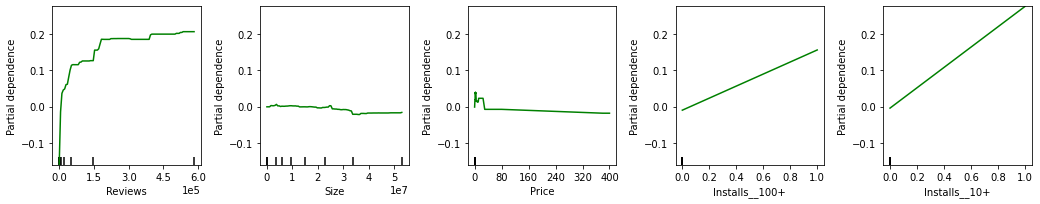

In [58]:
# Plot partial dependence
num_top_features = 5
fig, ax = plot_partial_dependence(best_estimator, X_train, sorted_idx[0:num_top_features], 
                                  n_cols=5, feature_names=X_train.columns, percentiles=(0.1, 0.9))
fig.set_figwidth(16)

In [59]:
threshold = np.percentile(y_train, 20)
threshold

3.8999999999999995

In [60]:
# Transform ratings into binary labels
y_train_binary = (y_train < threshold).astype(int)
y_test_binary = (y_test < threshold).astype(int)

In [61]:
# Set the parameters by cross-validation
tuned_parameters = [
    {
        'max_depth': [3, 4, 5], 
        'learning_rate': [0.3, 0.2, 0.1],
        'subsample': [1.0, 0.9, 0.8]
    }
]

print("# Tuning hyper-parameters")

# Train a GDBT classifier
clf = GridSearchCV(GradientBoostingClassifier(n_estimators=300), tuned_parameters, cv=5, scoring="f1")
clf.fit(X_train, y_train_binary)

# Tuning hyper-parameters


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=300,
                                                  n_iter_no_change=None,
         

In [62]:
print("Best parameters set found on training set:")
print(clf.best_params_)

Best parameters set found on training set:
{'learning_rate': 0.3, 'max_depth': 5, 'subsample': 1.0}


In [63]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("F1 score = %0.3f for %r" % (mean, params))

F1 score = 0.296 for {'learning_rate': 0.3, 'max_depth': 3, 'subsample': 1.0}
F1 score = 0.320 for {'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.9}
F1 score = 0.315 for {'learning_rate': 0.3, 'max_depth': 3, 'subsample': 0.8}
F1 score = 0.356 for {'learning_rate': 0.3, 'max_depth': 4, 'subsample': 1.0}
F1 score = 0.347 for {'learning_rate': 0.3, 'max_depth': 4, 'subsample': 0.9}
F1 score = 0.355 for {'learning_rate': 0.3, 'max_depth': 4, 'subsample': 0.8}
F1 score = 0.362 for {'learning_rate': 0.3, 'max_depth': 5, 'subsample': 1.0}
F1 score = 0.359 for {'learning_rate': 0.3, 'max_depth': 5, 'subsample': 0.9}
F1 score = 0.360 for {'learning_rate': 0.3, 'max_depth': 5, 'subsample': 0.8}
F1 score = 0.260 for {'learning_rate': 0.2, 'max_depth': 3, 'subsample': 1.0}
F1 score = 0.289 for {'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.9}
F1 score = 0.292 for {'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.8}
F1 score = 0.305 for {'learning_rate': 0.2, 'max_depth': 4, 'sub

In [64]:
best_estimator = clf.best_estimator_

In [64]:
# Make predictions using the train/testing set
y_pred_train = best_estimator.predict(X_train)
y_pred_test = best_estimator.predict(X_test)

# Accuracy
print("Accuracy (train): %.2f"
      % accuracy_score(y_train_binary, y_pred_train))
print("Accuracy (test): %.2f"
      % accuracy_score(y_test_binary, y_pred_test))

# Precision
print("Precision (train): %.2f"
      % precision_score(y_train_binary, y_pred_train))
print("Precision (test): %.2f"
      % precision_score(y_test_binary, y_pred_test))

# Recall
print("Recall (train): %.2f"
      % recall_score(y_train_binary, y_pred_train))
print("Recall (test): %.2f"
      % recall_score(y_test_binary, y_pred_test))

# F1 score
print("F1 score (train): %.2f"
      % f1_score(y_train_binary, y_pred_train))
print("F1 score (test): %.2f"
      % f1_score(y_test_binary, y_pred_test))

In [65]:
best_n_estimators = best_estimator.get_params()["n_estimators"]

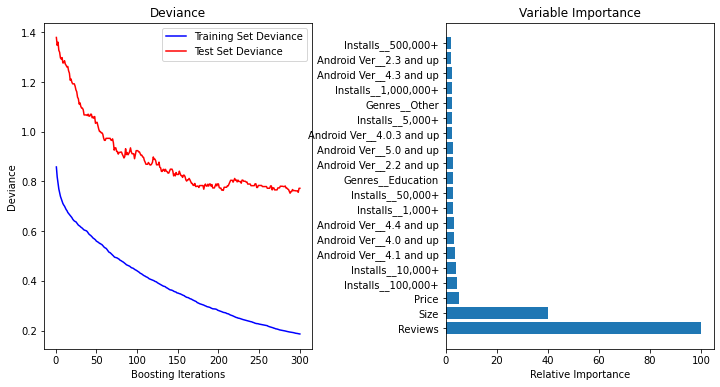

In [66]:
# Plot training deviance

# Compute test set deviance
test_score = np.zeros((best_n_estimators,), dtype=np.float64)
 
for i, y_pred_test in enumerate(best_estimator.staged_predict(X_test)):
    test_score[i] = best_estimator.loss_(y_test, y_pred_test)
    
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=.5)
plt.title('Deviance')
plt.plot(np.arange(best_n_estimators) + 1, best_estimator.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(best_n_estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance
feature_importance = best_estimator.feature_importances_
num_top_features = 20

# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1][0:num_top_features]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; The function ensemble.plot_partial_dependence has been deprecated in favour of sklearn.inspection.plot_partial_dependence in  0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dis

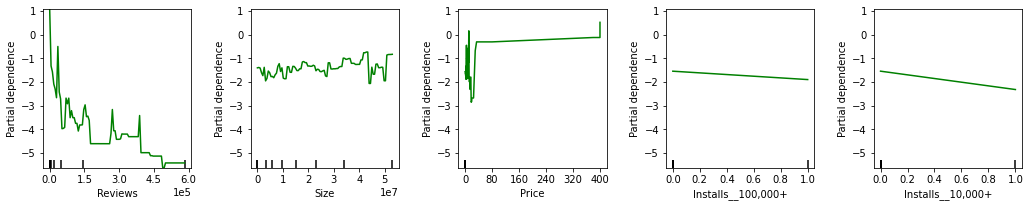

In [67]:
# Plot partial dependence
num_top_features = 5
fig, ax = plot_partial_dependence(best_estimator, X_train, sorted_idx[0:num_top_features], 
                                  n_cols=5, feature_names=X_train.columns, percentiles=(0.1, 0.9))
fig.set_figwidth(16)